<a href="https://colab.research.google.com/github/jayaaiyappan/Encoder_and_Decoder-Example/blob/master/Encoder_and_Decoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [180]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [193]:
import pandas as pd
ctg = pd.read_csv('/content/gdrive/My Drive/data/CTG.csv')
#ctg = pd.read_csv('/content/gdrive/My Drive/data/creditcard.csv')
# show first 10 records
ctg.head(10)

,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,DS,DP,DR,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,NSP
0,120.0,0.0,0.0,0.0,73.0,0.5,43.0,2.4,0.0,0.0,0.0,0.0,64.0,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,4.0,0.0,4.0,17.0,2.1,0.0,10.4,2.0,0.0,0.0,0.0,130.0,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,2.0,0.0,5.0,16.0,2.1,0.0,13.4,2.0,0.0,0.0,0.0,130.0,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,2.0,0.0,6.0,16.0,2.4,0.0,23.0,2.0,0.0,0.0,0.0,117.0,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,4.0,0.0,5.0,16.0,2.4,0.0,19.9,0.0,0.0,0.0,0.0,117.0,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0
5,134.0,1.0,0.0,10.0,26.0,5.9,0.0,0.0,9.0,0.0,2.0,0.0,150.0,50.0,200.0,5.0,3.0,76.0,107.0,107.0,170.0,0.0,3.0
6,134.0,1.0,0.0,9.0,29.0,6.3,0.0,0.0,6.0,0.0,2.0,0.0,150.0,50.0,200.0,6.0,3.0,71.0,107.0,106.0,215.0,0.0,3.0
7,122.0,0.0,0.0,0.0,83.0,0.5,6.0,15.6,0.0,0.0,0.0,0.0,68.0,62.0,130.0,0.0,0.0,122.0,122.0,123.0,3.0,1.0,3.0
8,122.0,0.0,0.0,1.0,84.0,0.5,5.0,13.6,0.0,0.0,0.0,0.0,68.0,62.0,130.0,0.0,0.0,122.0,122.0,123.0,3.0,1.0,3.0
9,122.0,0.0,0.0,3.0,86.0,0.3,6.0,10.6,0.0,0.0,0.0,0.0,68.0,62.0,130.0,1.0,0.0,122.0,122.0,123.0,1.0,1.0,3.0


In [194]:
ctg=ctg.dropna()
ctg=ctg.drop(ctg[ctg['NSP']==2].index)

ctg.shape

(1831, 23)

In [195]:
pd.value_counts(ctg['NSP'])

1.0    1655
3.0     176
Name: NSP, dtype: int64

In [196]:
#Peforming the scaling
from sklearn.model_selection import train_test_split

train_x, test_x = train_test_split(ctg, test_size=0.3, random_state=42)
train_x = train_x[train_x.NSP == 1] #where normal transactions
train_x = train_x.drop(['NSP'], axis=1) #drop the class column

test_y = test_x['NSP'] #save the class column for the test set
test_x = test_x.drop(['NSP'], axis=1) #drop the class column

train_x = train_x.values #transform to ndarray
test_x = test_x.values
train_x.shape, test_x.shape

((1155, 22), (550, 22))

In [232]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
encoding_dim=12
input_dim=train_x.shape[1]
inputArray=Input(shape=(input_dim,))
encoded=Dense(encoding_dim, activation='tanh')(inputArray)
decoded=Dense(input_dim, activation='softmax')(encoded)
autoencoder=Model(inputArray, decoded)
autoencoder.summary()

Model: "model_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_39 (InputLayer)        [(None, 22)]              0         
_________________________________________________________________
dense_117 (Dense)            (None, 12)                276       
_________________________________________________________________
dense_118 (Dense)            (None, 22)                286       
Total params: 562
Trainable params: 562
Non-trainable params: 0
_________________________________________________________________


In [233]:
from tensorflow.keras.optimizers import RMSprop
autoencoder.compile(optimizer=RMSprop(),
                    loss='mean_squared_error',
                    metrics=['accuracy'])

batch_size=32
epochs=20
history=autoencoder.fit(train_x,train_x,batch_size=batch_size,epochs=epochs,verbose=1,shuffle=True,
                        validation_data=(test_x,test_x))

score=autoencoder.evaluate(test_x, test_x, verbose=1)
print('Test loss:', score[0])
print('Accuracy:', score[1])

Epoch 1/20
37/37 [==============================] - 0s 4ms/step - loss: 5513.7329 - accuracy: 0.7628 - val_loss: 5564.3301 - val_accuracy: 0.9382
Epoch 2/20
37/37 [==============================] - 0s 3ms/step - loss: 5511.0703 - accuracy: 0.9706 - val_loss: 5562.3257 - val_accuracy: 0.9745
Epoch 3/20
37/37 [==============================] - 0s 3ms/step - loss: 5509.4697 - accuracy: 0.9887 - val_loss: 5561.1592 - val_accuracy: 0.9836
Epoch 4/20
37/37 [==============================] - 0s 3ms/step - loss: 5508.5156 - accuracy: 0.9905 - val_loss: 5560.3237 - val_accuracy: 0.9855
Epoch 5/20
37/37 [==============================] - 0s 3ms/step - loss: 5507.6562 - accuracy: 0.9931 - val_loss: 5559.4683 - val_accuracy: 0.9891
Epoch 6/20
37/37 [==============================] - 0s 2ms/step - loss: 5506.9458 - accuracy: 0.9931 - val_loss: 5558.9214 - val_accuracy: 0.9891
Epoch 7/20
37/37 [==============================] - 0s 3ms/step - loss: 5506.5400 - accuracy: 0.9931 - val_loss: 5558.6279 -

In [234]:
test_x_predictions = autoencoder.predict(test_x)
mse = np.mean(np.power(test_x - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': test_y})
error_df.describe()

,Reconstruction_error,True_class
count,550.000000,550.000000
mean,5558.341198,1.181818
std,1291.008263,0.575483
min,3475.825925,1.000000
25%,4794.759911,1.000000
50%,5474.332072,1.000000
75%,6104.729358,1.000000
max,19908.018873,3.000000


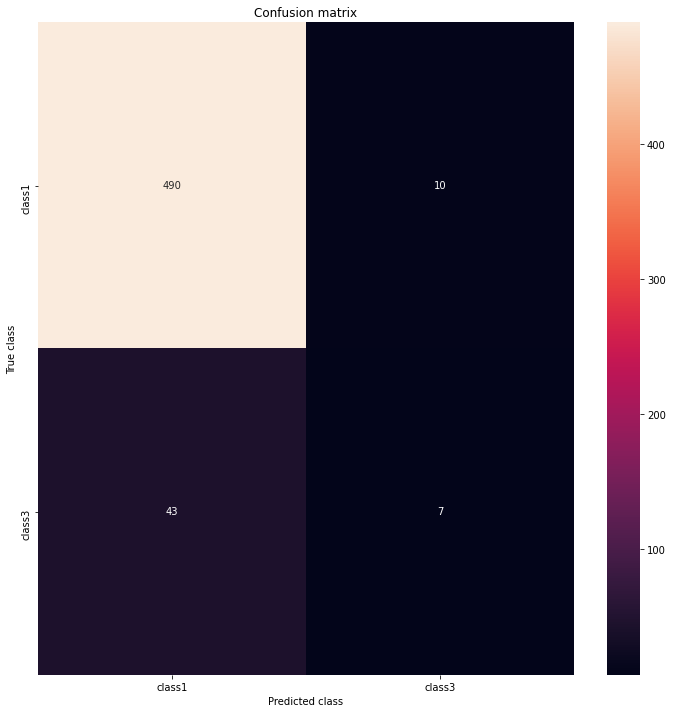

In [237]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
LABELS = ["class1","class3"]
threshold_fixed = 4000
pred_y = [1.0 if e > threshold_fixed else 3.0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [247]:
print(classification_report(test_y,pred_y))

              precision    recall  f1-score   support

         1.0       0.92      0.98      0.95       500
         3.0       0.41      0.14      0.21        50

    accuracy                           0.90       550
   macro avg       0.67      0.56      0.58       550
weighted avg       0.87      0.90      0.88       550

